In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
from sklearn import metrics

warnings.filterwarnings('ignore')


from sklearn import model_selection
from sklearn.model_selection import cross_val_score


In [2]:
def pythag(pf,pa,exp=11.5):
    return (pf**exp)/(pa**exp+pf**exp)

def pythagGame(df_game,exp=11.5):
    p={}
    for iteam in np.arange(1,3):
        pf = df_game['AdjO_'+str(iteam)]
        pa = df_game['AdjD_'+str(iteam)]
        p[str(iteam)] = pythag(pf,pa,exp)
    
    return p['1']*(1.-p['2'])/(p['1']+p['2']-2.*p['1']*p['2'])
    

In [3]:
teamType=pd.read_csv('data/team_type.csv')
teamTypeDict={}
for r in teamType.values:
    teamTypeDict[r[0]]=r[1]

In [4]:
# df=pd.read_csv('data/games/all_games_2017.csv',index_col=0)
# # df=pd.read_csv('data/games/tourn_games_2016.csv',index_col=0)
# # y=df['outcome']
# # dropLabels=['School_1','Conf_1','wpct_1','Rank_1','WL_1','sched_url_1', 'name_1',\
# #             'School_2','Conf_2','wpct_2','Rank_2','WL_2','sched_url_2', 'name_2', 'outcome']

# # y=df['outcome']
# dropLabels=['School_1','Conf_1','wpct_1','Rank_1','WL_1','sched_url_1', 'wpct_1','TmPts_1', 'OppPts_1',\
#             'School_2','Conf_2','wpct_2','Rank_2','WL_2','sched_url_2', 'wpct_2','TmPts_2', 'OppPts_2', 'outcome']
# # dropLabels.append('round')
# dfAll=df

In [6]:
# types=[]
# for r in df.itertuples():
    
#     t1=teamTypeDict[r.School_1]
#     t2=teamTypeDict[r.School_2]
    
#     types.append(str(min(t1,t2))+str(max(t1,t2)))
    
# df['types']=types

In [120]:
res=[]
dfAll=pd.DataFrame()
for year in np.arange(2017,2003,-1):
    df=pd.read_csv('data/games/tourn_games_'+str(year)+'.csv',index_col=0)
    dfAll=dfAll.append(df,ignore_index=True)


df2=dfAll.copy()
index=df2.keys()
index
df2.columns=[indx.replace('_1','_xx').replace('_2','_1').replace('_xx','_2') for indx in index]
df2.outcome=1-df2.outcome

dfAll=(df2.append(dfAll))

In [121]:
dropLabels=['School_1','Conf_1','wpct_1','Rank_1','WL_1','sched_url_1', 'name_1', 'wpct_1','TmPts_1', 'OppPts_1',\
            'School_2','Conf_2','wpct_2','Rank_2','WL_2','sched_url_2', 'name_2', 'wpct_2','TmPts_2', 'OppPts_2', 'outcome', 'region']
dropLabels.append('round')

## Regression on scaled inputs

In [162]:
from sklearn.preprocessing import StandardScaler

dfClean = dfAll.drop(dropLabels,axis=1).dropna(axis=1)
scaler=StandardScaler().fit(dfClean)

scaled=scaler.transform(dfClean)


X=scaled
y=dfAll['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# model = LogisticRegression(C=0.001,multi_class='multinomial',solver='sag')
model = LogisticRegression()
# model=RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

kfold = model_selection.KFold(n_splits=5, random_state=0)
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean())) 

# y_predPythag=pythagGame(X_test)

# print('Accuracy using pythagorean win expectation: %.3f' % ((np.round(y_predPythag)==y_test).sum()/len(y_test)))

# res.append([year,results.mean(),(np.round(y_predPythag)==y_test).sum()/len(y_test)])


10-fold cross validation average accuracy: 0.771


In [168]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

## Regression on non-scaled inputs

In [179]:
dropLabels=['outcome', 'region']
dropLabels.append('round')
for t12 in ['1', '2']:
    dropLabels.append('School_'+t12)
    dropLabels.append('name_'+t12)
    dropLabels.append('fullName_'+t12)
    dropLabels.append('Conf_'+t12)
    dropLabels.append('wpct_'+t12)
    dropLabels.append('Rank_'+t12)
    dropLabels.append('WL_'+t12)
    dropLabels.append('sched_url_'+t12)
    dropLabels.append('name_'+t12)
    dropLabels.append('TmPts_'+t12)
    dropLabels.append('OppPts_'+t12)
    dropLabels.append('SRS_'+t12)
    dropLabels.append('SOS_'+t12)
#     dropLabels.append('AdjO_'+t12)
#     dropLabels.append('AdjD_'+t12)
#     dropLabels.append('AdjT_'+t12)
#     dropLabels.append('Luck_'+t12)
    

In [180]:
dfClean=dfAll.drop(dropLabels,axis=1).dropna(axis=1)


features12=dfClean.keys()
features=[l.replace('_1','') for l in features12[::2]]
dfNew=pd.DataFrame()
for lab in features:
    dfNew[lab]=dfClean[lab+'_1']-dfClean[lab+'_2']


dfClean=dfNew

In [191]:
n_fold = 10
test_size = 0.2


cols=dfClean.columns
dfClean=dfClean[sorted(cols)]

scaler=StandardScaler().fit(dfClean)
scaled=scaler.transform(dfClean)
# X=scaled
X=dfClean

y=dfAll['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

# model = LogisticRegression(C=0.001,multi_class='multinomial',solver='sag')
model = LogisticRegression(C=0.01,penalty='l2',fit_intercept=True)
# model=RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)
kfold = model_selection.KFold(n_splits=n_fold, random_state=0)
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean())) 


# y_predPythag=pythagGame(X_test)

# print('Accuracy using pythagorean win expectation: %.3f' % ((np.round(y_predPythag)==y_test).sum()/len(y_test)))

# res.append([year,results.mean(),(np.round(y_predPythag)==y_test).sum()/len(y_test)])


10-fold cross validation average accuracy: 0.764


In [192]:
import pickle
from sklearn.externals import joblib
joblib.dump(model, 'app/model.pkl') 

features=dfClean.columns
joblib.dump(features,'app/features.pkl')

clf = joblib.load('app/model.pkl') 
featuresX=joblib.load('app/features.pkl')

# joblib.dump(scaler,'app/scaler.pkl')
pickle.dump(scaler, open('app/scaler.pkl', 'wb'))



In [119]:
row=10
print(dfAll.loc[row][['name_1','name_2']].values)
print(clf.predict_proba(dfClean)[row,:])

['southern-california' 'baylor']
[ 0.9035948  0.0964052]


# Write model to database

In [206]:

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
dbname = 'ncaabb'
username = 'gshau' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))



postgres://gshau@localhost/ncaabb
True


In [215]:
X_test

,3PAr_1,3PAr_2,AST%_1,AST%_2,AdjD_1,AdjD_2,AdjEM.1_1,AdjEM.1_2,AdjEM_1,AdjEM_2,...,STL%_1,STL%_2,TOV%_1,TOV%_2,TRB%_1,TRB%_2,TS%_1,TS%_2,eFG%_1,eFG%_2
8,0.369,0.433,51.9,52.3,92.1,92.5,10.00,9.33,22.99,29.88,...,10.3,11.0,14.3,15.0,54.7,53.0,0.542,0.612,0.521,0.575
50,0.315,0.313,52.3,49.3,104.4,95.5,-4.80,8.82,5.07,20.06,...,8.7,10.2,15.3,14.1,53.9,52.7,0.579,0.566,0.554,0.537
43,0.316,0.376,51.6,63.7,91.4,100.4,10.98,5.17,27.72,23.63,...,8.1,7.9,13.4,13.4,53.2,52.4,0.564,0.618,0.529,0.598
24,0.383,0.393,65.3,53.6,93.9,96.3,9.00,14.05,23.12,23.45,...,7.3,10.8,16.1,12.6,54.9,47.7,0.589,0.572,0.557,0.550
0,0.433,0.369,52.3,46.0,92.5,103.4,9.33,-4.49,29.88,-3.86,...,11.0,9.0,15.0,17.1,53.0,44.5,0.612,0.536,0.575,0.510
36,0.381,0.364,61.0,59.1,96.3,92.6,3.64,1.50,15.57,26.14,...,11.2,9.4,15.0,13.9,49.7,56.1,0.571,0.579,0.538,0.543
54,0.325,0.406,57.3,57.8,89.4,98.4,10.84,10.24,27.17,19.74,...,13.8,10.4,14.1,12.3,52.1,48.7,0.545,0.573,0.513,0.536
28,0.388,0.451,56.3,52.6,93.2,99.2,8.05,10.76,25.02,23.05,...,9.4,9.0,14.7,12.8,52.9,47.9,0.582,0.601,0.554,0.570
7,0.403,0.383,49.3,47.5,107.6,96.8,-2.86,11.43,2.04,24.17,...,8.5,8.7,15.3,14.2,51.8,51.9,0.565,0.588,0.528,0.548
49,0.411,0.361,57.1,57.0,98.7,99.0,7.74,11.73,14.34,16.70,...,8.0,8.8,16.3,15.7,50.3,54.4,0.557,0.553,0.523,0.519


In [214]:
clf.predict_proba(X_test)[:,0]

array([  9.57623480e-01,   7.81876146e-01,   3.99929639e-01,
         9.93293655e-01,   1.66162119e-04,   7.49443508e-01,
         7.08152189e-01,   5.81131725e-01,   9.99867038e-01,
         9.43839300e-01,   4.92500493e-01,   1.40034403e-01,
         3.44308068e-05,   9.97227627e-01,   4.74489418e-02,
         8.44144354e-01,   3.52564787e-05,   8.13510043e-01,
         9.99558962e-01,   9.99841631e-01,   3.14210278e-01,
         1.73099281e-01,   5.37261155e-02,   1.77038692e-01,
         1.45736724e-02,   9.95224125e-01])

In [255]:
import pickle
from sklearn.externals import joblib
joblib.dump(model, 'model.pkl') 

clf = joblib.load('model.pkl') 

# s = pickle.dumps(clf)
# clf2 = pickle.loads(s)

In [211]:
kfold = model_selection.KFold(n_splits=n_fold, random_state=0)
scoring = 'accuracy'
results = model_selection.cross_val_score(clf, X, y, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean())) 


10-fold cross validation average accuracy: 0.746


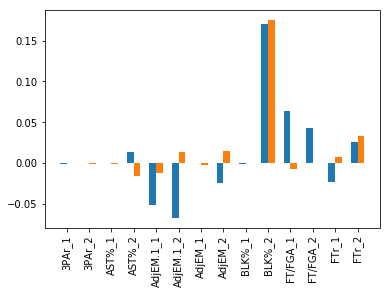

In [38]:
ndata=int(len(model.coef_[0])/2)
plt.bar(np.arange(ndata)-0.15, model.coef_[0][:ndata],width=0.3)
plt.bar(np.arange(ndata)+.15, -model.coef_[0][ndata:],width=0.3)
labels=dfClean.keys();
plt.xticks(np.arange(ndata), labels, rotation='vertical');


# Show logistic regression plot

In [19]:
def logit(x):
    return 1./(1.+np.exp(-x))
# logit(X_test.dot(model.coef_.T)).values-model.predict_proba(X_test)[:,1,None]

(-5, 5)

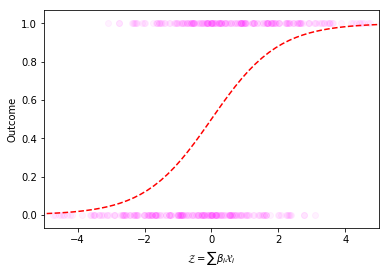

In [26]:
xcoord = X_test.dot(model.coef_.T)
plt.scatter(xcoord, y_test,color=[1,0,1,.05])
plt.scatter(-xcoord, 1-y_test,color=[1,0,1,.05])
plt.xlabel('${\cal Z}=\sum \\beta_i {\cal X}_i$')
plt.ylabel('Outcome')
x=np.linspace(-10,10,100)
plt.plot(x,logit(x),'r--')
plt.xlim(-5,5)

## Confusion Matrix


In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_test,np.round(y_predPythag))

ValueError: Found input variables with inconsistent numbers of samples: [221, 265]

In [29]:

confusion_matrix(y_test,y_pred)

array([[ 43,  37],
       [ 23, 118]])

In [165]:
rf=RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train,y_train)
pred=rf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.75113122171945701

In [166]:
resDF.plot(x='Log reg',y='Pythag',kind='scatter')
plt.xlim(0,1)
plt.ylim(0,1)

NameError: name 'resDF' is not defined

# Test with teams split by k-means and PCA

In [107]:
resultList=[]
for yr in np.arange(2017,2003,-1):
    year=str(yr)
    teamType=pd.read_csv('data/team_type_'+year+'.csv')
    teamTypeDict={}
    for r in teamType.values:
        teamTypeDict[r[0]]=r[1]

    df=pd.read_csv('data/games/all_games_'+year+'.csv',index_col=0).dropna(axis=1)
    # df=pd.read_csv('data/games/tourn_games_2016.csv',index_col=0)
    # y=df['outcome']
    dropLabels=['School_1','Conf_1','wpct_1','Rank_1','WL_1','sched_url_1',\
                'School_2','Conf_2','wpct_2','Rank_2','WL_2','sched_url_2', 'outcome']

    y=df['outcome']


    types=[]
    for r in df.itertuples():

        t1=teamTypeDict[r.School_1]
        t2=teamTypeDict[r.School_2]

        types.append(str(min(t1,t2))+str(max(t1,t2)))

    df['types']=types

    runsum=0
    numsum=0
    pythsum=0

    nlab=3
    for t1lab in range(nlab):
        for t2lab in np.arange(t1lab,nlab):
            lab = str(t1lab)+str(t2lab)

            dfSel = df[(df.types==lab)]
            dropLabels.append('types')

            X=dfSel.drop(dropLabels,axis=1)
            y=dfSel['outcome']


            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            logreg = LogisticRegression()
            logreg.fit(X_train, y_train)

            y_pred=logreg.predict(X_test)
            print(lab,len(y_pred))
            print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


            y_predPythag=pythagGame(X_test)

            print('Accuracy using pythagorean win expectation: ',(np.round(y_predPythag)==y_test).sum()/len(y_test))


            kfold = model_selection.KFold(n_splits=10, random_state=7)
            modelCV = LogisticRegression()
            scoring = 'accuracy'
            results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
            print("10-fold cross validation average accuracy: %.3f" % (results.mean()))    

            runsum+= len(y_pred) * results.mean() #logreg.score(X_test, y_test)
            numsum+= len(y_pred)
            pythsum+= len(y_pred) *(np.round(y_predPythag)==y_test).sum()/len(y_test)



    print ()
    print (runsum/numsum)
    print (pythsum/numsum)
    
    resultList.append([year,(runsum/numsum),pythsum/numsum])
    
resDFKM=pd.DataFrame(resultList,columns=['year','Log reg','Pythag'])


00 613
Accuracy of logistic regression classifier on test set: 0.67
Accuracy using pythagorean win expectation:  0.68515497553
10-fold cross validation average accuracy: 0.669
01 281
Accuracy of logistic regression classifier on test set: 0.84
Accuracy using pythagorean win expectation:  0.79359430605
10-fold cross validation average accuracy: 0.830
02 940
Accuracy of logistic regression classifier on test set: 0.77
Accuracy using pythagorean win expectation:  0.76170212766
10-fold cross validation average accuracy: 0.754
11 388
Accuracy of logistic regression classifier on test set: 0.65
Accuracy using pythagorean win expectation:  0.682989690722
10-fold cross validation average accuracy: 0.669
12 287
Accuracy of logistic regression classifier on test set: 0.92
Accuracy using pythagorean win expectation:  0.91637630662
10-fold cross validation average accuracy: 0.922
22 530
Accuracy of logistic regression classifier on test set: 0.70
Accuracy using pythagorean win expectation:  0.6943

10-fold cross validation average accuracy: 0.627
12 638
Accuracy of logistic regression classifier on test set: 0.82
Accuracy using pythagorean win expectation:  0.815047021944
10-fold cross validation average accuracy: 0.799
22 674
Accuracy of logistic regression classifier on test set: 0.68
Accuracy using pythagorean win expectation:  0.695845697329
10-fold cross validation average accuracy: 0.650

0.734948243054
0.771009174312
00 612
Accuracy of logistic regression classifier on test set: 0.64
Accuracy using pythagorean win expectation:  0.62091503268
10-fold cross validation average accuracy: 0.644
01 431
Accuracy of logistic regression classifier on test set: 0.88
Accuracy using pythagorean win expectation:  0.867749419954
10-fold cross validation average accuracy: 0.845
02 646
Accuracy of logistic regression classifier on test set: 0.77
Accuracy using pythagorean win expectation:  0.78173374613
10-fold cross validation average accuracy: 0.764
11 406
Accuracy of logistic regressio

In [109]:
resDFKM.mean()

year       1.440858e+54
Log reg    7.391709e-01
Pythag     7.464952e-01
dtype: float64

In [116]:

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.578


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
# logreg = LogisticRegression(C=1,penalty='l1',tol=0.1)
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.70


In [11]:
df['pythag']=pythagGame(df)

In [15]:
y_predPythag=pythagGame(X_test)

print('Accuracy using pythagorean win expectation: ',(np.round(y_predPythag)==y_test).sum()/len(y_test))
# print(len(y_test))

Accuracy using pythagorean win expectation:  0.739459815547
